In [48]:
import sys
!{sys.executable} -m pip install plotly


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [49]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def plot_confidence(probs, class_names, pred_class):
    """
    Plot a horizontal bar chart showing the model's confidence
    for each pose class.
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    
    colors = ['green' if i == pred_class else 'gray' for i in range(len(probs))]
    ax.barh(class_names, probs, color=colors)
    
    ax.set_xlabel('Probability')
    ax.set_title('Pose Classification Confidence')
    plt.tight_layout()
    plt.show()
    
    return fig


def create_angle_radar(user_angles, typical_angles, angle_names):
    """
    Create a radar chart comparing the user's joint angles to
    the typical (mean) angles for the predicted pose.
    """
    fig = go.Figure()
    
    fig.add_trace(go.Scatterpolar(
        r=user_angles,
        theta=angle_names,
        fill='toself',
        name='Your Pose'
    ))
    
    fig.add_trace(go.Scatterpolar(
        r=typical_angles,
        theta=angle_names,
        fill='toself',
        name='Ideal Pose'
    ))
    
    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True)),
        showlegend=True
    )
    
    return fig


In [50]:
import os
import pickle
import math
import numpy as np
import cv2
import mediapipe as mp
import torch
import torch.nn as nn

MODELS_DIR = "models"
MODEL_PATH = os.path.join(MODELS_DIR, "yoga_angle_resnet.pt")
META_PATH  = os.path.join(MODELS_DIR, "yoga_angle_resnet_meta.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

with open(META_PATH, "rb") as f:
    meta = pickle.load(f)

class_names = meta["class_names"]
feature_cols = meta["feature_cols"]
angle_stats = meta["angle_stats"]
hidden_dim = meta.get("hidden_dim", 256)

print("Classes:", class_names)
print("Num features:", len(feature_cols))

Using device: cpu
Classes: ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']
Num features: 12


In [51]:
# load model
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        out = out + x
        out = self.act(out)
        return out


class AngleResNet(nn.Module):
    def __init__(self, in_dim, num_classes, hidden_dim=256, num_blocks=3, dropout=0.5):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout=dropout)
            for _ in range(num_blocks)
        ])
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        h = self.input_layer(x)
        h = self.blocks(h)
        logits = self.head(h)
        return logits

in_dim = len(feature_cols)
num_classes = len(class_names)
model = AngleResNet(in_dim, num_classes, hidden_dim=hidden_dim, num_blocks=3, dropout=0.5).to(device)

state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("Model loaded.")

Model loaded.


In [52]:
mp_pose = mp.solutions.pose

def calculate_angle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    angle = math.degrees(
        math.atan2(y3 - y2, x3 - x2) -
        math.atan2(y1 - y2, x1 - x2)
    )
    if angle < 0:
        angle += 360
    return angle


def angles_finder(landmarks):
    P = mp_pose.PoseLandmark

    left_elbow_angle = calculate_angle(
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.LEFT_ELBOW.value],
        landmarks[P.LEFT_WRIST.value]
    )
    right_elbow_angle = calculate_angle(
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_ELBOW.value],
        landmarks[P.RIGHT_WRIST.value]
    )

    left_shoulder_angle = calculate_angle(
        landmarks[P.LEFT_ELBOW.value],
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.LEFT_HIP.value]
    )
    right_shoulder_angle = calculate_angle(
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_ELBOW.value]
    )

    left_knee_angle = calculate_angle(
        landmarks[P.LEFT_HIP.value],
        landmarks[P.LEFT_KNEE.value],
        landmarks[P.LEFT_ANKLE.value]
    )
    right_knee_angle = calculate_angle(
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_KNEE.value],
        landmarks[P.RIGHT_ANKLE.value]
    )

    hand_angle = calculate_angle(
        landmarks[P.LEFT_ELBOW.value],
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_ELBOW.value]
    )

    left_hip_angle = calculate_angle(
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.LEFT_HIP.value],
        landmarks[P.LEFT_KNEE.value]
    )
    right_hip_angle = calculate_angle(
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_KNEE.value]
    )

    neck_angle_uk = calculate_angle(
        landmarks[P.NOSE.value],
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.RIGHT_SHOULDER.value]
    )

    left_wrist_angle_bk = calculate_angle(
        landmarks[P.LEFT_WRIST.value],
        landmarks[P.LEFT_HIP.value],
        landmarks[P.LEFT_ANKLE.value]
    )
    right_wrist_angle_bk = calculate_angle(
        landmarks[P.RIGHT_WRIST.value],
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_ANKLE.value]
    )

    return {
        "left_elbow_angle": left_elbow_angle,
        "right_elbow_angle": right_elbow_angle,
        "left_shoulder_angle": left_shoulder_angle,
        "right_shoulder_angle": right_shoulder_angle,
        "left_knee_angle": left_knee_angle,
        "right_knee_angle": right_knee_angle,
        "hand_angle": hand_angle,
        "left_hip_angle": left_hip_angle,
        "right_hip_angle": right_hip_angle,
        "neck_angle_uk": neck_angle_uk,
        "left_wrist_angle_bk": left_wrist_angle_bk,
        "right_wrist_angle_bk": right_wrist_angle_bk,
    }

In [53]:
def landmarks_from_image(image_bgr):
    mp_drawing = mp.solutions.drawing_utils
    with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=False,
        min_detection_confidence=0.5
    ) as pose:

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if not results.pose_landmarks:
            return None, None

        h, w, _ = image_bgr.shape
        landmarks = []
        for lm in results.pose_landmarks.landmark:
            landmarks.append((int(lm.x * w), int(lm.y * h), lm.z * w))

        # create an annotated image for display
        out_img = image_bgr.copy()
        mp_drawing.draw_landmarks(
            image=out_img,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS
        )

        return out_img, landmarks

In [54]:
POSE_ANGLE_WHITELIST = {
    "downdog": [
        "left_shoulder_angle", "right_shoulder_angle",
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_wrist_angle_bk", "right_wrist_angle_bk",
        "neck_angle_uk",
    ],
    "plank": [
        "left_shoulder_angle", "right_shoulder_angle",
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_elbow_angle", "right_elbow_angle",
        "neck_angle_uk",
    ],
    "goddess": [
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_shoulder_angle", "right_shoulder_angle",
    ],
    "tree": [
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_shoulder_angle", "right_shoulder_angle",
    ],
    "warrior2": [
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_shoulder_angle", "right_shoulder_angle",
        "hand_angle",
    ],
}

def circular_diff(a, b):
    """
    difference between two angles in degrees, result is in [-180, 180].
    """
    return (a - b + 180) % 360 - 180

In [55]:
def describe_angle_feedback(pose, angle_name, diff, side):
    """
    turn an angle deviation into a human-readable coaching tip.
    """
    more = diff > 0  # angle larger than typical
    side_word = f"{side} " if side else ""

    def hips_too_high_low():
        if more:
            return f"Lower your {side_word}hip slightly; it's higher than the usual alignment."
        else:
            return f"Lift your {side_word}hip a bit; it's lower than the usual alignment."

    def knee_straight_vs_soft():
        if more:
            return f"Straighten your {side_word}knee a bit more."
        else:
            return f"Slightly soften your {side_word}knee instead of locking it."

    def shoulder_open_vs_stack():
        if more:
            return f"Push the floor away and open your {side_word}shoulder a bit more."
        else:
            return f"Stack your {side_word}shoulder more strongly; don't let it collapse."

    def wrist_line_feedback():
        if more:
            return f"Bring your {side_word}arm closer to a straight line from shoulder to wrist."
        else:
            return f"Relax your {side_word}arm a bit; it's straighter than typical."

    def neck_feedback():
        if more:
            return "Lengthen the back of your neck; your head is tipped more than usual."
        else:
            return "Gently relax your neck; you're keeping it more neutral than most samples."

    # pose specific logic
    # Downdog & Plank
    if pose in ["downdog", "plank"]:
        if "hip_angle" in angle_name:
            return hips_too_high_low()
        if "knee_angle" in angle_name:
            return knee_straight_vs_soft()
        if "shoulder_angle" in angle_name:
            return shoulder_open_vs_stack()
        if "wrist_angle_bk" in angle_name:
            return wrist_line_feedback()
        if "neck_angle" in angle_name:
            return neck_feedback()

    # Goddess & Warrior2: big bent knees + open hips
    if pose in ["goddess", "warrior2"]:
        if "knee_angle" in angle_name:
            if more:
                return f"Bend your {side_word}knee a bit deeper."
            else:
                return f"Straighten your {side_word}knee just a touch."
        if "hip_angle" in angle_name:
            if more:
                return f"Draw your {side_word}hip slightly under you; it's more open than typical."
            else:
                return f"Open your {side_word}hip slightly more to the side."
        if "shoulder_angle" in angle_name:
            return shoulder_open_vs_stack()
        if "hand_angle" in angle_name:
            if more:
                return "Level your arms; one arm is lifted higher than usual."
            else:
                return "Lift your arms to a level line; they're lower than typical."

    # Tree: balance + standing leg alignment
    if pose == "tree":
        if "knee_angle" in angle_name:
            if more:
                return f"Press your {side_word}knee out a bit more for a wider opening."
            else:
                return f"Keep your {side_word}knee from collapsing inward."
        if "hip_angle" in angle_name:
            if more:
                return f"Square your {side_word}hip a bit more; it's opening more than usual."
            else:
                return f"Open your {side_word}hip slightly to the side."
        if "shoulder_angle" in angle_name:
            return shoulder_open_vs_stack()
        if "neck_angle" in angle_name:
            return neck_feedback()
    
    return None # no cutom rules

In [56]:
# Mapping from internal feature names to more human-readable labels
FRIENDLY_NAMES = {
    "left_hip_angle": "left hip angle",
    "right_hip_angle": "right hip angle",
    "left_knee_angle": "left knee bend",
    "right_knee_angle": "right knee bend",
    "left_elbow_angle": "left elbow angle",
    "right_elbow_angle": "right elbow angle",
    "neck_angle_uk": "neck alignment",
    "left_shoulder_angle": "left shoulder angle",
    "right_shoulder_angle": "right shoulder angle",
    "left_ankle_angle": "left ankle angle",
    "right_ankle_angle": "right ankle angle",
    # Add more mappings here if needed
}

def pretty_name(name: str) -> str:
    """
    Convert an internal feature name to a human-friendly label.
    """
    return FRIENDLY_NAMES.get(name, name.replace("_", " "))


def classify_severity(diff: float, threshold: float) -> str:
    """
    Classify how severe the deviation is compared to the threshold.
    
    diff: signed angular difference (in degrees)
    threshold: cutoff for flagging the joint
    """
    ratio = abs(diff) / max(threshold, 1e-6)
    if ratio < 1.2:
        return "mild"
    elif ratio < 1.8:
        return "moderate"
    else:
        return "severe"


In [ ]:
def analyze_image(image_path, std_factor=2.0, min_deg=10.0, show_image=True):
    """
    Analyze a single yoga-pose image:
    - Run Mediapipe pose detection
    - Compute joint angles
    - Predict pose with the trained model
    - Generate detailed angle-based feedback
    - Visualize classification confidence and angle radar chart
    - Show skeleton overlay image
    
    Parameters
    ----------
    image_path : str
        Path to the input image file.
    std_factor : float
        Multiplier on standard deviation for flagging abnormal angles.
    min_deg : float
        Minimum absolute angle difference (in degrees) to flag.
    show_image : bool
        Whether to display the skeleton overlay image.
    """

    # 1. Load image and run MediaPipe pose detection
    img = cv2.imread(image_path)
    if img is None:
        print("Could not read image:", image_path)
        return

    out_img, landmarks = landmarks_from_image(img)
    if landmarks is None:
        print("No pose detected.")
        return

    # Extract joint angles from detected landmarks
    angle_dict = angles_finder(landmarks)

    # Convert angle dictionary into feature vector for model input
    feats = [angle_dict.get(name, 0.0) for name in feature_cols]
    x = torch.tensor(feats, dtype=torch.float32, device=device).unsqueeze(0)

    # 2. Predict pose class using the trained model
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

        cls_idx = int(np.argmax(probs))
        cls_name = class_names[cls_idx]
        confidence = probs[cls_idx]

    print(f"Predicted pose: {cls_name} (prob = {confidence:.3f})")

    # Plot classification confidence bar chart
    try:
        plot_confidence(probs, class_names, cls_idx)
    except Exception as e:
        print("Could not plot confidence bar chart:", e)

    # 3. Retrieve statistical angle data for the predicted pose
    stats = angle_stats.get(cls_name, None)
    if stats is None:
        print("No angle stats found for this pose (should not happen).")
        return

    mean_angles = np.array(stats["mean"])
    std_angles  = np.array(stats["std"])

    # Determine which angles should be evaluated for this pose
    whitelist = POSE_ANGLE_WHITELIST.get(cls_name, feature_cols)

    print(
        "\nFeedback (we flag joints where |difference| > "
        f"max({std_factor} * std, {min_deg}°)):"
    )

    any_flag = False
    violations = []  # to compute overall score and Top-3 later

    # 4. Compare user's joint angles with typical pose statistics
    for name, value, mean, std in zip(feature_cols, feats, mean_angles, std_angles):
        if name not in whitelist:
            continue

        diff = circular_diff(value, mean)
        threshold = max(min_deg, std_factor * std)

        if abs(diff) < threshold:
            continue

        any_flag = True
        severity = classify_severity(diff, threshold)
        side = "left" if "left_" in name else "right" if "right_" in name else ""
        direction = "more" if diff > 0 else "less"

        # Save for summary/top-3
        violations.append((name, diff, threshold, severity))

        # Coaching-style textual feedback
        text = describe_angle_feedback(cls_name, name, diff, side)
        if text is None:
            text = (
                f"Your {pretty_name(name)} is about "
                f"{abs(diff):.1f}° {direction} than typical."
            )

        print(
            f"  - ({severity}) {text} "
            f"(your {pretty_name(name)}: {value:.1f}°, "
            f"typical: {mean:.1f}°; "
            f"≈{abs(diff):.1f}° {direction}, "
            f"threshold ≈{threshold:.1f}°)"
        )

    # 4.1 If everything is within range
    if not any_flag:
        print("All checked joint angles look good!")

    # 4.2 Compute overall alignment score and Top-3 problematic joints
    total_checked = len([n for n in feature_cols if n in whitelist])
    bad = len(violations)
    good = total_checked - bad
    score = max(0.0, 100.0 * good / max(total_checked, 1))

    print(f"\nOverall alignment score: {score:.1f} / 100")
    print(f"Joints within tolerance: {good}/{total_checked}")
    print(f"Joints needing attention: {bad}/{total_checked}")

    if violations:
        # Sort by normalized deviation (|diff| / threshold), descending
        violations_sorted = sorted(
            violations,
            key=lambda v: abs(v[1]) / max(v[2], 1e-6),
            reverse=True
        )
        top3 = violations_sorted[:3]

        print("\nFocus first on these joints:")
        for name, diff, threshold, severity in top3:
            direction = "more" if diff > 0 else "less"
            print(
                f"  * ({severity}) {pretty_name(name)} "
                f"(≈{abs(diff):.1f}° {direction}, "
                f"threshold ≈{threshold:.1f}°)"
            )

    if good > 0 and bad > 0:
        print(f"\nNice work! {good} joints are already within the target range.")

    # Plot radar chart comparing user vs. ideal pose
    try:
        angle_names = [pretty_name(name) for name in feature_cols if name in whitelist]
        user_angles = [angle_dict.get(name, 0.0) for name in feature_cols if name in whitelist]
        typical_angles = [
            mean for name, mean in zip(feature_cols, mean_angles) if name in whitelist
        ]

        fig_radar = create_angle_radar(user_angles, typical_angles, angle_names)
        fig_radar.show()
    except Exception as e:
        print("Could not plot angle radar chart:", e)

    # 5. Display original image with skeleton overlay
    if show_image:
        plt.figure(figsize=(5, 8))
        plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted: {cls_name}")
        plt.axis("off")
        plt.show()


I0000 00:00:1764561663.970944 2197649 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1764561664.044102 2449103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561664.081946 2449106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Predicted pose: Downdog (prob = 1.000)


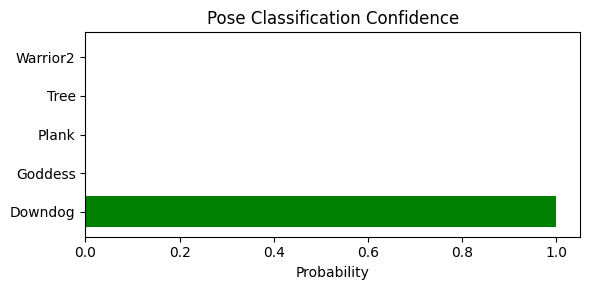


Feedback (we flag joints where |difference| > max(1.0 * std, 20°)):
  - (moderate) Your left knee bend is about 27.6° less than typical. (your left knee bend: 151.6°, typical: 179.2°; ≈27.6° less, threshold ≈20.0°)
  - (moderate) Your right knee bend is about 25.3° less than typical. (your right knee bend: 154.6°, typical: 179.9°; ≈25.3° less, threshold ≈20.0°)
  - (moderate) Your neck alignment is about 136.7° less than typical. (your neck alignment: 61.5°, typical: 198.2°; ≈136.7° less, threshold ≈101.0°)

Overall alignment score: 75.0 / 100
Joints within tolerance: 9/12
Joints needing attention: 3/12

Focus first on these joints:
  * (moderate) left knee bend (≈27.6° less, threshold ≈20.0°)
  * (moderate) neck alignment (≈136.7° less, threshold ≈101.0°)
  * (moderate) right knee bend (≈25.3° less, threshold ≈20.0°)

Nice work! 9 joints are already within the target range.
Could not plot angle radar chart: Mime type rendering requires nbformat>=4.2.0 but it is not installed


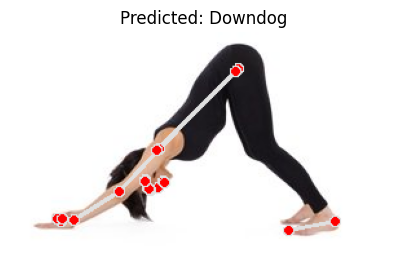

In [58]:
test_image = "test/test3.jpg"
analyze_image(test_image, std_factor=1.0, min_deg=20)